In [1]:
#Libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

## Data Preparation

In [2]:
#Loading Data
DATA=pd.read_excel(r'../../Datasets/ML2-PreMon.xlsx',sheet_name='Sheet1')
y=pd.Series(DATA.LWP)
X=DATA.loc[:,~DATA.columns.isin(['LWP'])]#Select Everything Other than LWP

#Split dataset into training set and test set
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3)#80% training and 20% test

In [67]:
DATA.head()

,PBLH,RH,WindDirection-850,MeanWind-850,V-850,SMOKE-AOD,DUST-AOD,PrecipitableVapour,PrecidCal,LTS,Nd,LWP
0,724.208728,33.209657,283.306357,9.374429,0.058580,0.177522,0.054197,3.24450,0.064389,14.011322,45.087664,9.75
1,724.625391,35.340314,280.441298,9.143348,0.082056,0.189754,0.065570,3.05550,0.134013,13.792267,25.081423,10.75
2,636.185706,35.371513,284.427631,7.089826,0.067495,0.183994,0.052897,3.02275,0.000000,13.880829,20.189200,9.25
3,609.739880,36.337872,316.275613,4.393169,0.055905,0.127734,0.050990,3.65400,0.000000,13.435699,27.442801,52.50
4,590.828455,30.572250,308.161604,4.369788,0.063334,0.125449,0.050004,3.58500,0.000000,13.518738,20.332886,26.25


## Model training

### For GBRT

In [40]:
%%script echo skipping
#Create gradientboost Regressor object
from sklearn.ensemble import GradientBoostingRegressor
myModel=GradientBoostingRegressor(max_depth=8,n_estimators=150,learning_rate=0.05)

skipping


### For RandomForest

In [68]:
#Create RandomForest Regressor object
from sklearn.ensemble import RandomForestRegressor
# myModel=RandomForestRegressor(random_state=42)

#WithBestParams
myModel=RandomForestRegressor(random_state=42,
                        n_estimators=115,
                        min_samples_split=10,
                        
                        min_samples_leaf=2,
                        max_features='sqrt',
                        max_depth=70,bootstrap=False)

### to See the params

In [33]:
myModel.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

## Model Running

In [69]:
#Training
model=myModel.fit(X_train,y_train)
#Testing
y_pred=model.predict(X_test)

## Model Evalutation

In [42]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score,f1_score

In [44]:
methods=['R-Squared', 'Adjusted R-Squared', 'Mean Absolute Error (MAE)', 'Mean Squared Error (MSE)', 'RMSE']
values=[]

values.append(r2_score(y_test,y_pred)) #1.R-Squared
values.append(1 - (1-model.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))#2.Adjusted R-Squared
values.append(mean_absolute_error(y_test, y_pred))#3.MAE
values.append(mean_squared_error(y_test, y_pred))#4.MSE
values.append(np.sqrt(mean_squared_error(y_test, y_pred)))#5.RMSE
# values.append(f1_score(y_test,y_pred))#6.F1 Score

eval_df = pd.DataFrame({'Method Name' : methods, 'Values': values})
eval_df

,Method Name,Values
0,R-Squared,0.393382
1,Adjusted R-Squared,0.391598
2,Mean Absolute Error (MAE),18.492019
3,Mean Squared Error (MSE),837.161827
4,RMSE,28.933749


## Ploting the Importance

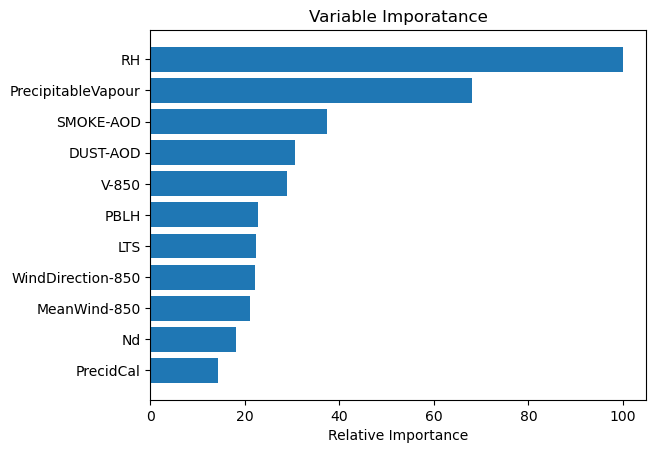

In [70]:
import matplotlib.pyplot as plt

#plot feature importance
feature_importance = model.feature_importances_

#make importances relative to mac importance
feature_importance=100.0 * (feature_importance/feature_importance.max())
sorted_idx=np.argsort(feature_importance)
pos=np.arange(sorted_idx.shape[0])+.5
plt.barh(pos, feature_importance[sorted_idx],align='center')
plt.yticks(pos, DATA.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Imporatance')
plt.show()

## Tuning hyperparameters

### For GBRT

In [ ]:
%%script echo skipping
from sklearn.model_selection import GridSearchCV
LR={'learning_rate':[0.15,0.10,0.05],'n_estimators':[100,150,200,250]}
tuning=GridSearchCV(estimator=myModel,
            param_grid=LR,scoring='r2')
tuning.fit(X_train,y_train)
tuning.best_params_, tuning.best_score_



Selected:
({'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 250},0.3665469426033763)


### For RandomForest

In [58]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 80, num = 10)]
# Number of features to consider at every split
max_features = ['sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(2, 10, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 4, 6]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

In [59]:
# Create the param grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(param_grid)

{'n_estimators': [10, 17, 25, 33, 41, 48, 56, 64, 72, 80], 'max_features': ['sqrt'], 'max_depth': [2, 2, 3, 4, 5, 6, 6, 7, 8, 9, 10, None], 'min_samples_split': [2, 4, 6], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [60]:
from sklearn.model_selection import RandomizedSearchCV
model = myModel
rf_RandomGrid = RandomizedSearchCV(estimator = model, param_distributions = param_grid, cv = 10, verbose=2, n_jobs = 4)

In [61]:
rf_RandomGrid.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] END bootstrap=False, max_depth=6, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=17; total time=   0.8s
[CV] END bootstrap=False, max_depth=6, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=17; total time=   0.8s
[CV] END bootstrap=False, max_depth=6, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=17; total time=   0.8s
[CV] END bootstrap=False, max_depth=6, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=17; total time=   0.8s
[CV] END bootstrap=False, max_depth=6, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=17; total time=   0.7s
[CV] END bootstrap=False, max_depth=6, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=17; total time=   0.7s
[CV] END bootstrap=False, max_depth=6, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=17; total time=

RandomizedSearchCV(cv=10, estimator=RandomForestRegressor(random_state=42),
                   n_jobs=4,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [2, 2, 3, 4, 5, 6, 6, 7, 8,
                                                      9, 10, None],
                                        'max_features': ['sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 4, 6],
                                        'n_estimators': [10, 17, 25, 33, 41, 48,
                                                         56, 64, 72, 80]},
                   verbose=2)

In [62]:
rf_RandomGrid.best_params_

{'n_estimators': 56,
 'min_samples_split': 4,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': False}

In [63]:
print (f'Train Accuracy - : {rf_RandomGrid.score(X_train,y_train):.3f}')
print (f'Test Accuracy - : {rf_RandomGrid.score(X_test,y_test):.3f}')

Train Accuracy - : 0.991
Test Accuracy - : 0.422
